In [118]:
import numpy as np
import Scripts.cifar_resnet as rn
import Scripts.wake_processing as wp
import importlib
import Scripts.autoencoder as ae
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
%matplotlib inline

In [85]:
importlib.reload(rn)
importlib.reload(wp)

<module 'Scripts.wake_processing' from 'E:\\Studies\\Deep Water\\DeepWater\\Scripts\\wake_processing.py'>

## Training Data

In [3]:
real_wakes = np.load("Data\\Wake data\\confirmed_wakes.npy")
generated_wakes = np.load("Data\\Wake data\\generated_wakes.npy")
not_wakes = np.load("Data\\Wake data\\negative_day_samples.npy")
real_wakes = real_wakes[:,:,:-1,:]
not_wakes = not_wakes[:,:,:-1,:]
train_real, test_real = train_test_split(real_wakes, test_size=0.2, random_state=4)
train_gen, test_gen = train_test_split(generated_wakes, test_size=0.08, random_state=4)
train_neg, test_neg = train_test_split(not_wakes, test_size = 0.06, random_state = 4)
test_pos = np.append(test_real, test_gen, axis = 0)
train_pos = np.append(train_real, train_gen, axis = 0)
test_x = np.append(test_pos, test_neg, axis = 0)
train_x = np.append(train_pos, train_neg, axis = 0)
test_pos_y = np.concatenate((np.ones(test_pos.shape[0]).reshape(-1,1), np.zeros(test_pos.shape[0]).reshape(-1,1)), axis = 1)
test_neg_y = np.concatenate((np.zeros(test_neg.shape[0]).reshape(-1,1), np.ones(test_neg.shape[0]).reshape(-1,1)), axis = 1)
train_pos_y = np.concatenate((np.ones(train_pos.shape[0]).reshape(-1,1), np.zeros(train_pos.shape[0]).reshape(-1,1)), axis = 1)
train_neg_y = np.concatenate((np.zeros(train_neg.shape[0]).reshape(-1,1), np.ones(train_neg.shape[0]).reshape(-1,1)), axis = 1)
test_y = np.append(test_pos_y, test_neg_y, axis = 0)
train_y = np.append(train_pos_y, train_neg_y, axis = 0)

In [4]:
train_dataset = TensorDataset(torch.Tensor(train_x), torch.Tensor(train_y))
test_dataset = TensorDataset(torch.Tensor(test_x), torch.Tensor(test_y))

In [5]:
test_dataset.tensors[0].shape

torch.Size([118, 4, 28, 60])

In [6]:
test_dataset.tensors[1].shape

torch.Size([118, 2])

## Training

In [7]:
def train_rn(model, train_data, test_data, num_epochs=5, batch_size=5, learning_rate=1e-3):
    model = model.to(device)
    torch.manual_seed(0)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=0, drop_last=True)
    X_val, y_val = test_data.tensors[0].to(device), test_data.tensors[1].to(device)
    train_losses = []
    val_losses = []
    val_accs = []
    train_accs= []
    for epoch in range(num_epochs):
        total_loss = []
        batch_accs = []
        for i, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_pred_label = 1 - torch.argmax(pred, dim = 1).cpu().detach().numpy()
            train_true_label = 1 - torch.argmax(y, dim = 1).cpu().detach().numpy()
            batch_acc = accuracy_score(train_true_label, train_pred_label)
            batch_accs.append(batch_acc)
            total_loss.append(loss.item())
            
        val_pred = model(X_val)
        val_pred_label = 1 - torch.argmax(val_pred, dim = 1).cpu().detach().numpy()
        val_true_label = 1 - torch.argmax(y_val, dim = 1).cpu().detach().numpy()
        val_loss = criterion(val_pred, y_val).item()
        train_loss = sum(total_loss)/len(total_loss)
        train_acc = sum(batch_accs)/len(batch_accs)
        val_acc = accuracy_score(val_true_label, val_pred_label)
        print('Epoch:{}, Loss:{:.4f}, Val Loss:{:.4f}, Train Acc:{:4f}, Val Acc:{:.4f}'.format(epoch+1, train_loss,
                                                                                               val_loss, train_acc, val_acc))
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        train_accs.append(train_acc)
    return train_losses, val_losses, train_accs, val_accs

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
#device = torch.device("cpu")

In [11]:
resnet = None
resnet = rn.ResNet18()
train_losses, val_losses, train_accs, val_accs = train_rn(resnet, train_dataset, test_dataset, num_epochs = 30, learning_rate=1e-4)

Epoch:1, Loss:0.2818, Val Loss:0.2719, Train Acc:0.888406, Val Acc:0.8983
Epoch:2, Loss:0.1474, Val Loss:0.3146, Train Acc:0.949275, Val Acc:0.8983
Epoch:3, Loss:0.1008, Val Loss:0.2479, Train Acc:0.965942, Val Acc:0.9237
Epoch:4, Loss:0.0870, Val Loss:0.3226, Train Acc:0.969565, Val Acc:0.8983
Epoch:5, Loss:0.0369, Val Loss:0.2477, Train Acc:0.989855, Val Acc:0.9407
Epoch:6, Loss:0.0467, Val Loss:0.3834, Train Acc:0.983333, Val Acc:0.8814
Epoch:7, Loss:0.0118, Val Loss:0.3774, Train Acc:0.997826, Val Acc:0.9153
Epoch:8, Loss:0.0018, Val Loss:0.4499, Train Acc:1.000000, Val Acc:0.9068
Epoch:9, Loss:0.0284, Val Loss:0.4502, Train Acc:0.990580, Val Acc:0.8983
Epoch:10, Loss:0.0502, Val Loss:0.4310, Train Acc:0.980435, Val Acc:0.9068
Epoch:11, Loss:0.0050, Val Loss:0.3321, Train Acc:0.999275, Val Acc:0.9407
Epoch:12, Loss:0.0031, Val Loss:0.7810, Train Acc:1.000000, Val Acc:0.8814
Epoch:13, Loss:0.0032, Val Loss:0.3391, Train Acc:0.999275, Val Acc:0.9407
Epoch:14, Loss:0.0029, Val Loss:0.

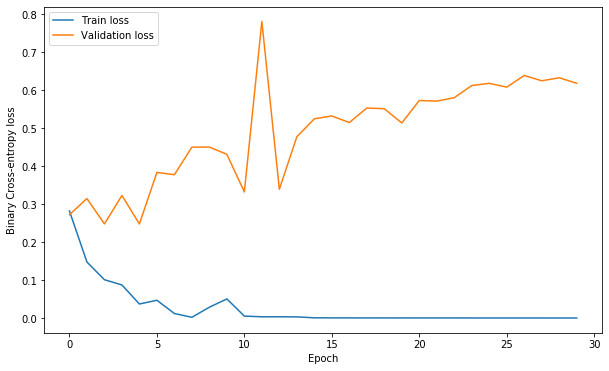

In [14]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label = 'Train loss')
plt.plot(val_losses, label = 'Validation loss')
plt.legend(loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-entropy loss')
plt.show()

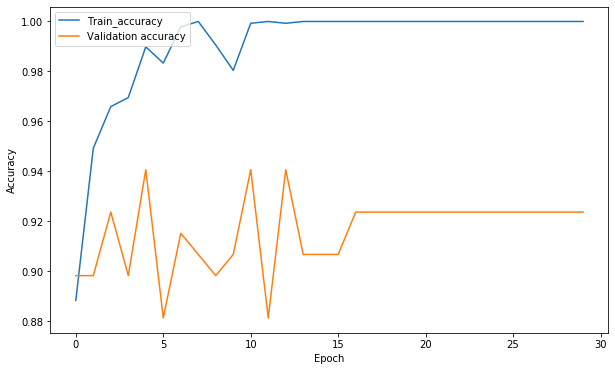

In [16]:
plt.figure(figsize=(10,6))
plt.plot(train_accs, label = 'Train_accuracy')
plt.plot(val_accs, label = 'Validation accuracy')
plt.legend(loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## Training with limited epochs

In [9]:
resnet = None
resnet = rn.ResNet18()
train_losses, val_losses, train_accs, val_accs = train_rn(resnet, train_dataset, test_dataset, num_epochs = 15, learning_rate=1e-4)

Epoch:1, Loss:0.2858, Val Loss:0.2096, Train Acc:0.894203, Val Acc:0.9322
Epoch:2, Loss:0.1583, Val Loss:0.3746, Train Acc:0.949275, Val Acc:0.8644
Epoch:3, Loss:0.1212, Val Loss:0.2859, Train Acc:0.951449, Val Acc:0.9237
Epoch:4, Loss:0.0742, Val Loss:0.3215, Train Acc:0.972464, Val Acc:0.9068
Epoch:5, Loss:0.0471, Val Loss:0.3847, Train Acc:0.981884, Val Acc:0.8814
Epoch:6, Loss:0.0396, Val Loss:0.4091, Train Acc:0.988406, Val Acc:0.8983
Epoch:7, Loss:0.0338, Val Loss:0.8015, Train Acc:0.985507, Val Acc:0.8220
Epoch:8, Loss:0.0378, Val Loss:0.3038, Train Acc:0.986957, Val Acc:0.9237
Epoch:9, Loss:0.0043, Val Loss:0.3325, Train Acc:1.000000, Val Acc:0.9322
Epoch:10, Loss:0.0124, Val Loss:0.6298, Train Acc:0.996377, Val Acc:0.8475
Epoch:11, Loss:0.0131, Val Loss:0.3564, Train Acc:0.996377, Val Acc:0.9237
Epoch:12, Loss:0.0556, Val Loss:0.4314, Train Acc:0.981884, Val Acc:0.8983
Epoch:13, Loss:0.0234, Val Loss:0.4810, Train Acc:0.991304, Val Acc:0.8983
Epoch:14, Loss:0.0146, Val Loss:0.

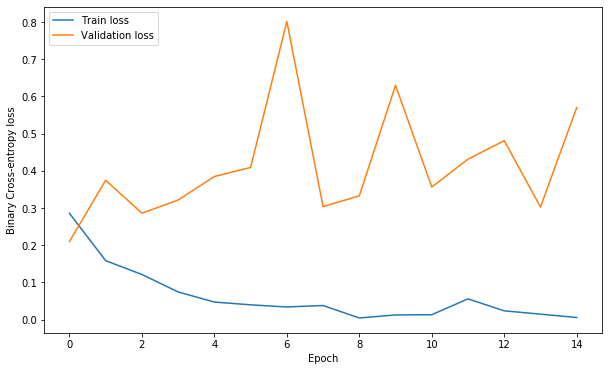

In [10]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label = 'Train loss')
plt.plot(val_losses, label = 'Validation loss')
plt.legend(loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-entropy loss')
plt.show()

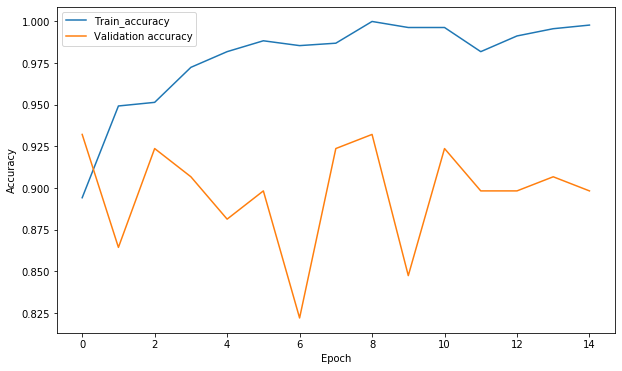

In [11]:
plt.figure(figsize=(10,6))
plt.plot(train_accs, label = 'Train_accuracy')
plt.plot(val_accs, label = 'Validation accuracy')
plt.legend(loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## Passing Full Training Dataset

In [12]:
data_series = wp.get_files()
cutoff = np.where(data_series[0,-2]<wp.date_to_stamp([9, 22, 0, 0]))[0][-1]
train_series = data_series[:,:,:cutoff]
test_series = data_series[:,:,cutoff:]

In [134]:
predictions = []
for i in tqdm(range((train_series.shape[2] - 60) // 5)):
    if train_series[0, -1, 5*i] == 1:
        time = train_series[0, -2, 5*i]
        next_frame = torch.from_numpy(train_series[:,:-2,5*i:5*i+60]).float().unsqueeze(0).to(device)
        label = int(torch.argmax(resnet(next_frame), dim = 1).cpu().detach())
        predictions.append(np.array([time, label]))     

100%|███████████████████████████████████████████████████████████████████████████| 13824/13824 [01:57<00:00, 117.84it/s]


In [135]:
predictions = np.array(predictions)

In [136]:
predicted_ws = predictions[np.where(predictions[:,1] == 0)][:,0]

In [137]:
wake_start = wp.get_wakes()
new_ws = wake_start
for ws in wake_start:
    if ws not in set(data_series[0,-2,:]):
        if ws-12 in set(data_series[0,-2,:]):
            new_ws = np.append(new_ws, ws-12)

In [138]:
unknown_wakes = predicted_ws
for ws in new_ws:
    unknown_wakes = unknown_wakes[np.where((ws-1800 >= unknown_wakes) | (unknown_wakes  >= ws+1800))]

In [139]:
predicted_wakes = wp.frames_by_timestamps(train_series[:,:-1,:], unknown_wakes)

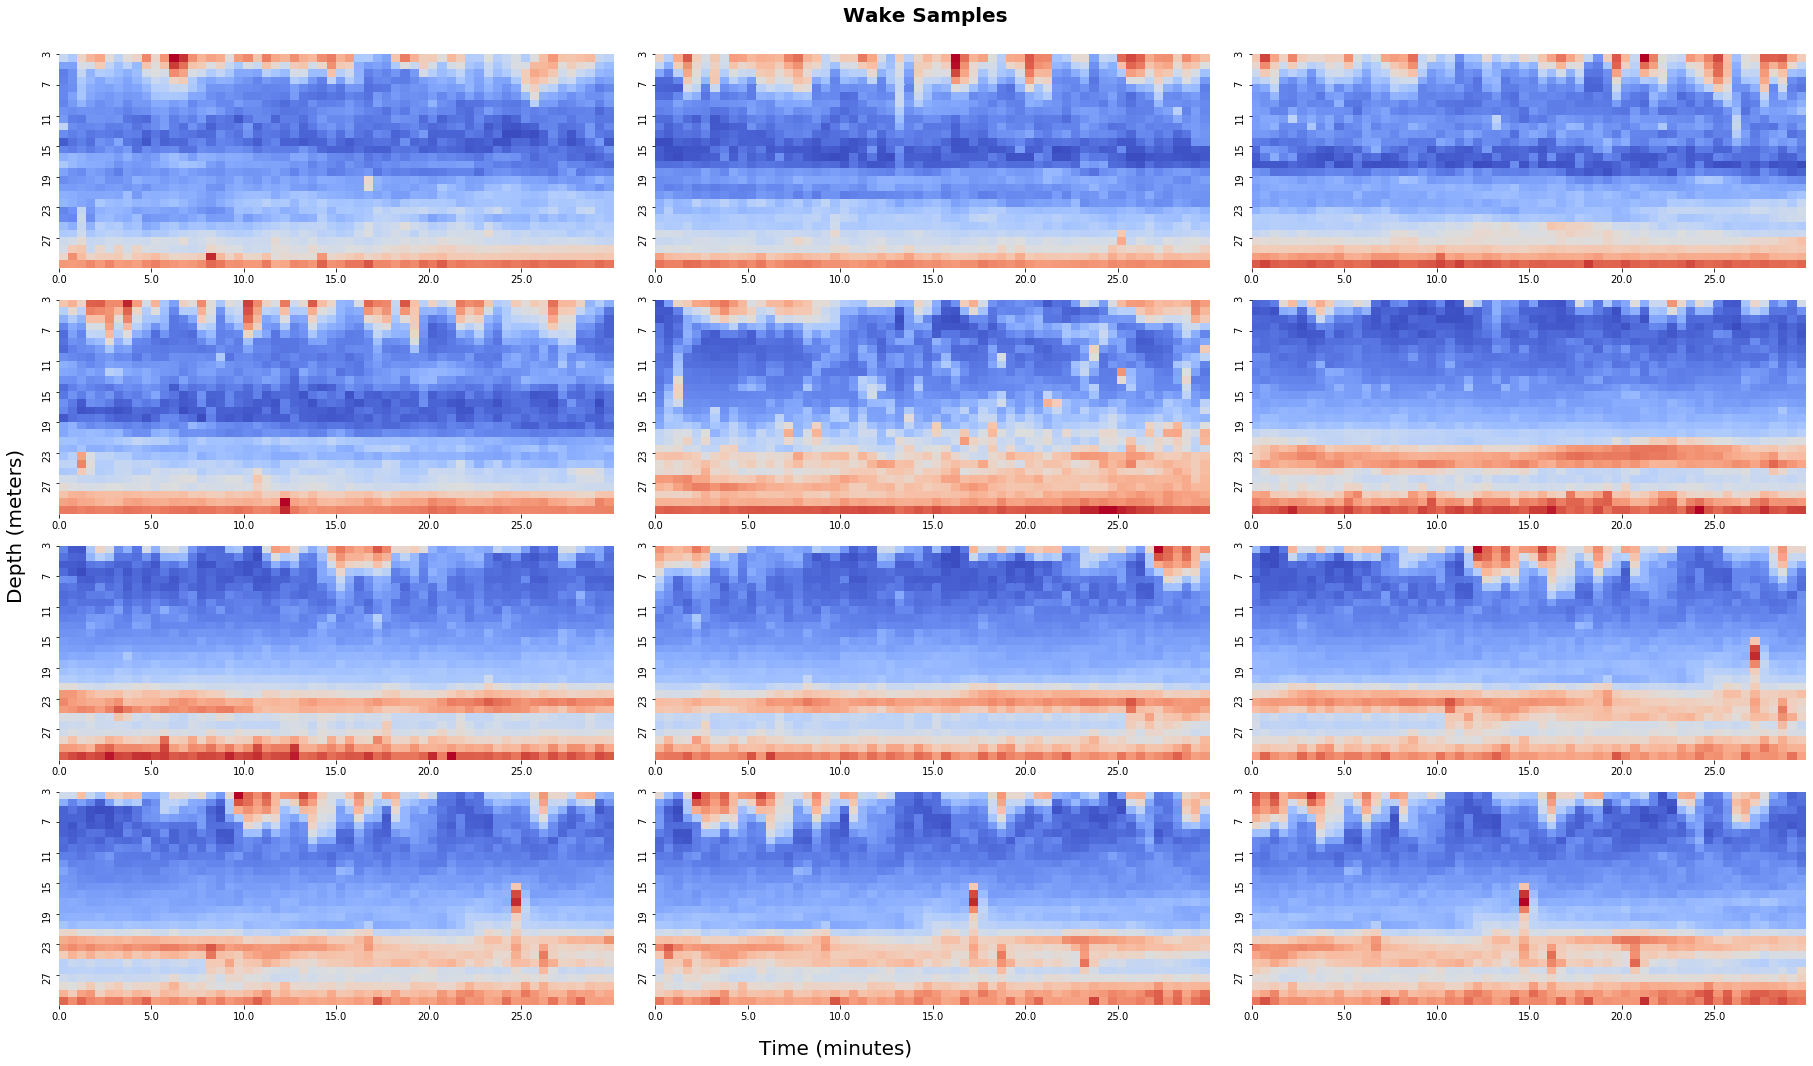

In [140]:
wp.make_12_heatmaps(predicted_wakes[:12, 3, :-1,:])

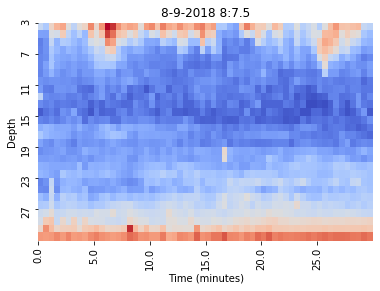

In [105]:
wp.make_heatmap(predicted_wakes[0, 3, :-1,:], predicted_wakes[0, 3,-1,:])

In [112]:
days = []
for uw in unknown_wakes:
    days.append(wp.stamp_to_date(uw)[1])

In [141]:
Counter(days) # Day: false negatives

Counter({8.0: 4,
         10.0: 1,
         11.0: 8,
         12.0: 28,
         13.0: 6,
         14.0: 2,
         15.0: 43,
         16.0: 7,
         17.0: 22,
         18.0: 40,
         19.0: 51,
         20.0: 57,
         21.0: 50})

Periods of noise according to the data description:
-	2018-09-08 07:00 – 2018-09-09 14:00
-	2018-09-11 07:00 - 2018-09-13 00:00  
-	2018-09-16 12:00 - 2018-09-17 10:00  
-	2018-09-18 08:00 - 2018-09-18 19:00  
-	2018-09-19 12:00 - 2018-09-20 17:00
-	2018-09-21 00:00 - 2018-09-23 10:00 
